In [ ]:
!pip install supervision ultralytics roboflow pytesseract rfdetr inference

#Object detection

In [ ]:
import supervision as sv
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import cv2 # Import cv2

model = RFDETRBase()

def callback(frame, index):
    # Convert 4-channel frame to 3-channel if necessary
    if frame.shape[-1] == 4:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)

    # Add .copy() after slicing to ensure a contiguous array with positive strides
    detections = model.predict(frame[:, :, ::-1].copy(), threshold=0.5)

    labels = [
        f"{COCO_CLASSES[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    annotated_frame = frame.copy()
    annotated_frame = sv.BoxAnnotator().annotate(annotated_frame, detections)
    annotated_frame = sv.LabelAnnotator().annotate(annotated_frame, detections, labels)
    return annotated_frame

sv.process_video(
    source_path= "https://media.roboflow.com/supervision/video-examples/people-walking.mp4",
    target_path="/content/annotated_video.mp4",
    callback=callback
)

Loading pretrain weights


#People Tracking

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import sys
from IPython.display import Video

# Path to your video file
VIDEO_PATH = 'https://media.roboflow.com/supervision/video-examples/people-walking.mp4'
MODEL_PATH = "yolov8n.pt"
model = YOLO(MODEL_PATH)

# Annotation coordinates from 1198x675 image
ANNOT_LINE_IN_START = (37/2556, 310/1382)
ANNOT_LINE_IN_END   = (2543/2556, 310/1382)
ANNOT_LINE_OUT_START = (57/2556, 990/1382)
ANNOT_LINE_OUT_END   = (2517/2556, 957/1382)

# human class IDs in COCO dataset
HUMAN_CLASS_ID = [0]

def main():
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print('Failed to open video file.')
        return

    # Get video size
    ret, frame = cap.read()
    if not ret:
        print('Failed to read first frame.')
        return
    orig_h, orig_w = frame.shape[:2]

    # Scale annotation coordinates
    def scale_point(pt, w, h):
        x, y = pt
        return (int(x * w), int(y * h))

    LINE_IN_START  = scale_point(ANNOT_LINE_IN_START, orig_w, orig_h)
    LINE_IN_END    = scale_point(ANNOT_LINE_IN_END, orig_w, orig_h)
    LINE_OUT_START = scale_point(ANNOT_LINE_OUT_START, orig_w, orig_h)
    LINE_OUT_END   = scale_point(ANNOT_LINE_OUT_END, orig_w, orig_h)

    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_counting.mp4', fourcc, 20, (orig_w, orig_h))

    in_count = 0
    out_count = 0
    already_counted_in = set()
    already_counted_out = set()
    track_history = {}

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, tracker="botsort.yaml", verbose=False)[0]
        boxes = results.boxes
        if boxes is None or boxes.xyxy is None:
            out.write(frame)
            continue

        class_ids = boxes.cls.cpu().numpy().astype(int)
        xyxy = boxes.xyxy.cpu().numpy()
        track_ids = boxes.id.cpu().numpy().astype(int) if boxes.id is not None else [None]*len(xyxy)
        human_indices = [i for i, cid in enumerate(class_ids) if cid in HUMAN_CLASS_ID]

        # Draw lines
        cv2.line(frame, LINE_IN_START, LINE_IN_END, (255, 0, 0), 2)
        cv2.line(frame, LINE_OUT_START, LINE_OUT_END, (0, 0, 255), 2)

        for idx in human_indices:
            x1, y1, x2, y2 = map(int, xyxy[idx])
            track_id = track_ids[idx]
            center = ((x1 + x2) // 2, (y1 + y2) // 2)

            if track_id not in track_history:
                track_history[track_id] = []
            track_history[track_id].append(center)
            if len(track_history[track_id]) > 2:
                track_history[track_id] = track_history[track_id][-2:]

            if len(track_history[track_id]) == 2:
                prev_center, curr_center = track_history[track_id]
                if (
                    LINE_IN_START[0] <= prev_center[0] <= LINE_IN_END[0] and
                    LINE_IN_START[0] <= curr_center[0] <= LINE_IN_END[0]
                ):
                    if prev_center[1] < LINE_IN_START[1] and curr_center[1] >= LINE_IN_START[1] and track_id not in already_counted_in:
                        in_count += 1
                        already_counted_in.add(track_id)
                if (
                    LINE_OUT_START[0] <= prev_center[0] <= LINE_OUT_END[0] and
                    LINE_OUT_START[0] <= curr_center[0] <= LINE_OUT_END[0]
                ):
                    if prev_center[1] > LINE_OUT_START[1] and curr_center[1] <= LINE_OUT_START[1] and track_id not in already_counted_out:
                        out_count += 1
                        already_counted_out.add(track_id)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
            cv2.circle(frame, center, 5, (0, 255, 0), -1)
            cv2.putText(frame, f'ID {track_id}', (center[0]-10, center[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        cv2.putText(frame, f'In: {in_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2.2, (0,255,0), 5)
        cv2.putText(frame, f'Out: {out_count}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 2.2, (0,0,255), 5)

        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # Show the video inside Colab
    return Video('output_counting.mp4', embed=True)

if __name__ == '__main__':
    main()


#Heatmap


0: 384x640 37 persons, 2 birds, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Processed 0 frames...


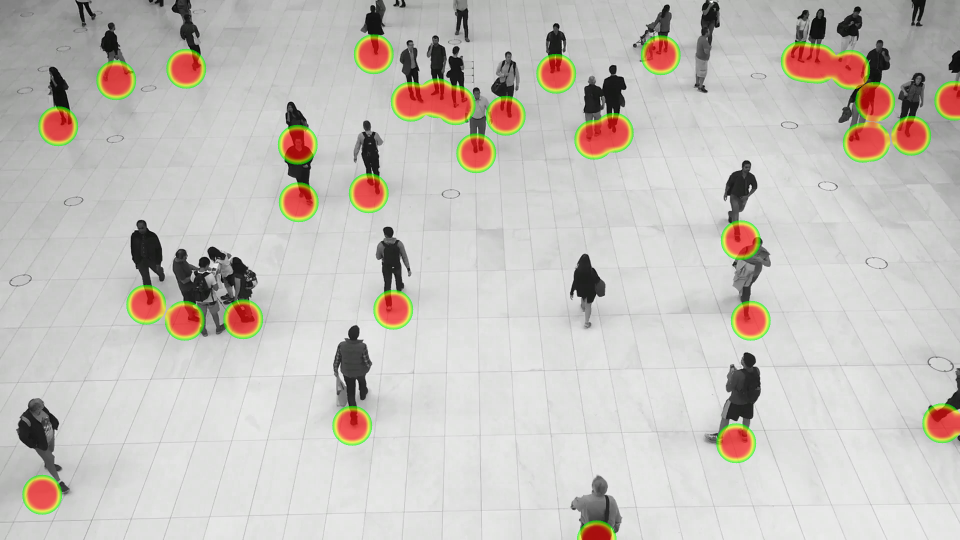


0: 384x640 38 persons, 3 birds, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 3 birds, 13.3ms
Speed: 3.2ms preprocess, 13.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 3 birds, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 2 birds, 9.7ms
Speed: 4.1ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 2 birds, 7.6ms
Speed: 3.3ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 8.5ms
Speed: 3.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 2 birds, 8.3ms
Speed: 3.2ms

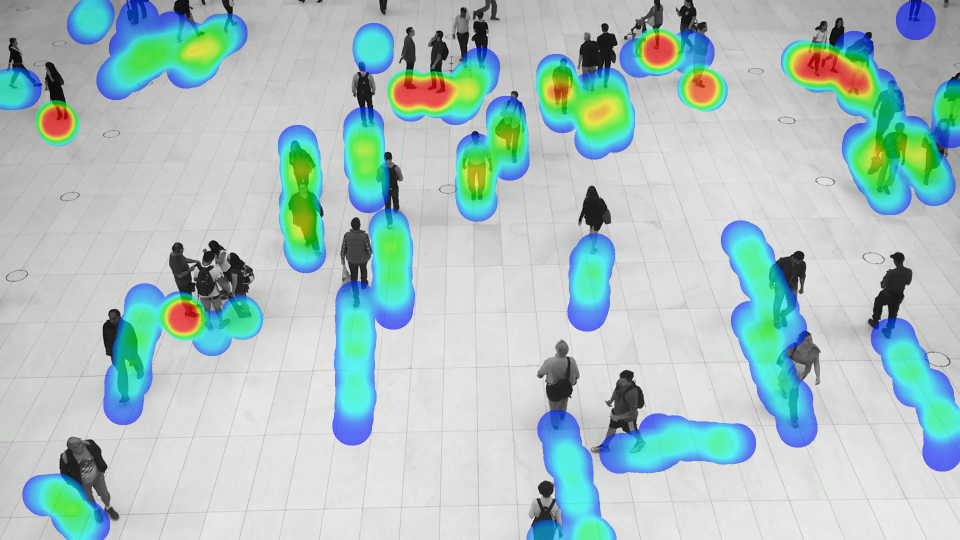


0: 384x640 41 persons, 1 bird, 1 dog, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 1 bird, 2 dogs, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 1 bird, 1 dog, 13.1ms
Speed: 3.3ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 40 persons, 1 dog, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 7.8ms
Speed: 9.5ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 39 persons, 1 bird, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 1 bird, 17.2ms
Speed: 3.2ms preprocess, 17.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 1 bird, 12.2ms
Spee

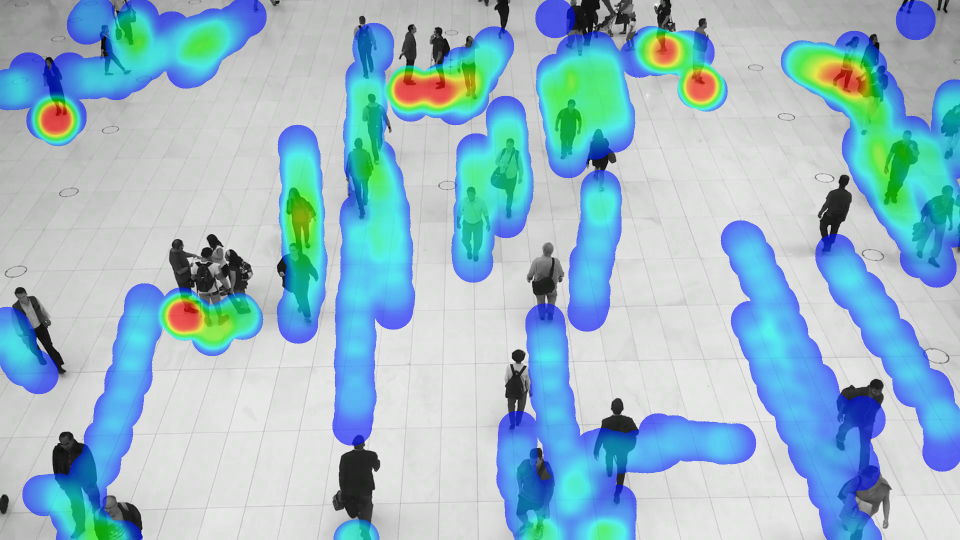


0: 384x640 38 persons, 1 backpack, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 1 dog, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 1 bird, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 11.1ms
Speed: 3.3ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 33 persons, 1 bird, 19.5ms
Speed: 3.3ms preprocess, 19.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 1 bird, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference,

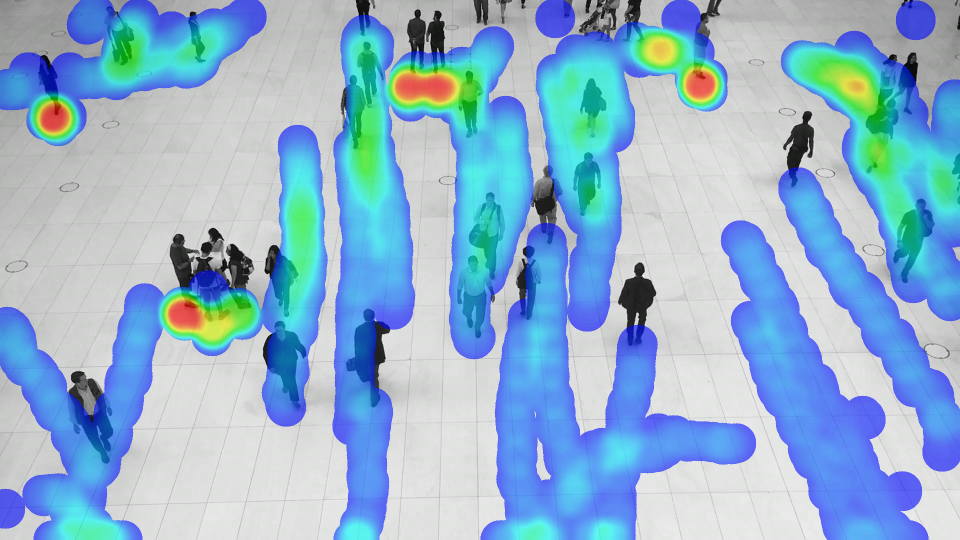


0: 384x640 30 persons, 1 bird, 11.2ms
Speed: 5.1ms preprocess, 11.2ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 1 bird, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 9.4ms
Speed: 6.0ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 30 persons, 12.4ms
Speed: 8.2ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 30 persons, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 26 persons, 1 bird, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.6ms postprocess 

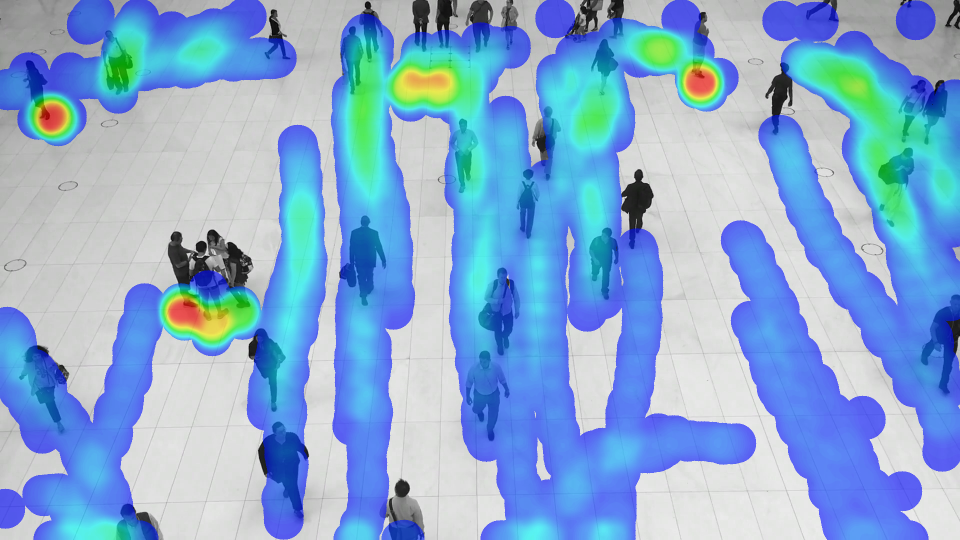


0: 384x640 32 persons, 9.5ms
Speed: 7.5ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 1 motorcycle, 1 handbag, 11.2ms
Speed: 4.8ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 1 handbag, 8.7ms
Speed: 5.6ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 31 persons, 1 motorcycle, 1 handbag, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 1 horse, 1 handbag, 10.1ms
Speed: 5.5ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 2 motorcycles, 1 horse, 1 handbag, 11.6ms
Speed: 5.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 1 horse, 1 backpack, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.6ms postprocess per image a

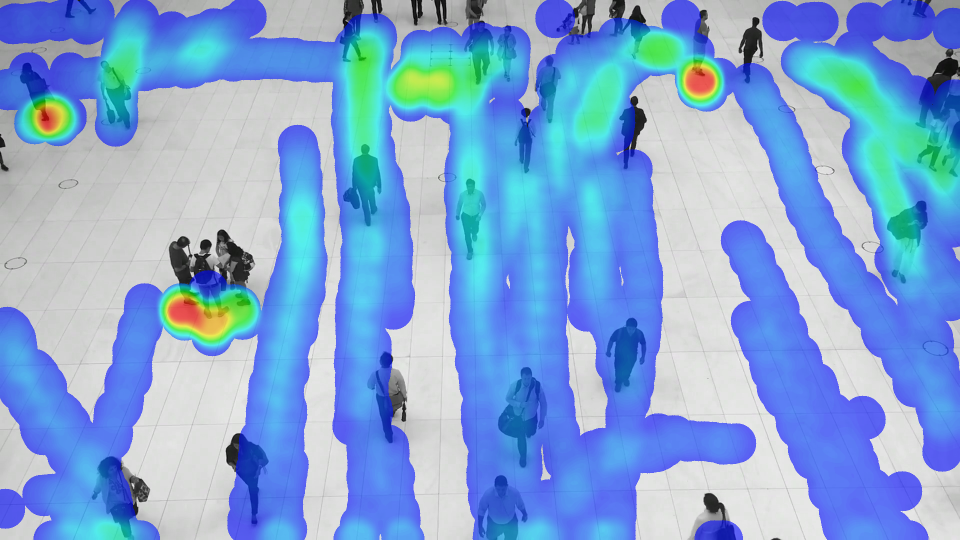


0: 384x640 25 persons, 1 handbag, 14.2ms
Speed: 3.1ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 27 persons, 1 handbag, 11.5ms
Speed: 3.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 1 handbag, 8.1ms
Speed: 5.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 1 handbag, 7.5ms
Speed: 4.2ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 30 persons, 1 bird, 1 handbag, 12.1ms
Speed: 3.7ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 7.8ms
Speed: 7.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 7.6ms
Speed: 4.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 8.1ms
Speed: 4.6ms prepro

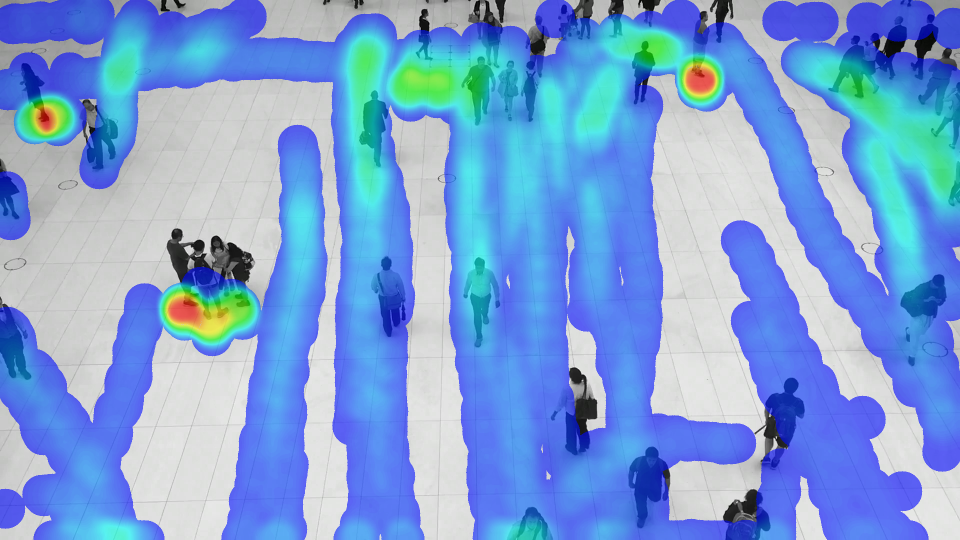


0: 384x640 28 persons, 1 dog, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 1 dog, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 26 persons, 1 bird, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 1 bird, 7.5ms
Speed: 3.5ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 1 bird, 1 umbrella, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 31 persons, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 1 bird, 1 dog, 1 umbrella, 12.9ms
Spee

In [ ]:
!pip install ultralytics supervision opencv-python-headless

import cv2
from ultralytics import YOLO
import supervision as sv
from google.colab.patches import cv2_imshow

VIDEO_PATH = 'https://media.roboflow.com/supervision/video-examples/people-walking.mp4'
MODEL_PATH = 'yolov8n.pt'
OUTPUT_PATH = 'output_heatmap.mp4'

def main():
    model = YOLO(MODEL_PATH)
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print('Failed to open video file.')
        return

    # Video writer setup
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

    # Initialize Supervision HeatMapAnnotator
    heatmap_annotator = sv.HeatMapAnnotator(
        opacity=0.6,
        radius=40,
        kernel_size=25,
        top_hue=0,      # red
        low_hue=120     # blue
    )

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Detect people
        result = model(frame)[0]
        detections = sv.Detections.from_ultralytics(result)
        # Filter for people (class_id == 0)
        mask = detections.class_id == 0
        detections.xyxy = detections.xyxy[mask]
        detections.confidence = detections.confidence[mask]
        detections.class_id = detections.class_id[mask]

        # Annotate heatmap
        frame_with_heatmap = heatmap_annotator.annotate(scene=frame.copy(), detections=detections)

        # Write frame to output video
        out.write(frame_with_heatmap)

        # Optional: display a few frames inline in Colab
        if frame_count % 50 == 0:
            print(f'Processed {frame_count} frames...')
            cv2_imshow(cv2.resize(frame_with_heatmap, (width//2, height//2)))

        frame_count += 1

    cap.release()
    out.release()
    print(f"Video saved to {OUTPUT_PATH}")

if __name__ == '__main__':
    main()
